# CS1470/2470 HW1: KNN (with CIFAR)

In this homework assignment, you will experience the overall machine learning process from start to end by implementing your own version of the **k-Nearest Neighbors** algorithm.

In [138]:
!python -VV

Python 3.8.13 (default, Mar 28 2022, 06:16:26) 
[Clang 12.0.0 ]


If you are running the notebook on Colab, you need to mount your drive or repo. An example of these is provided [here](https://colab.research.google.com/drive/1ioIGn7zOp46lgMEcL4P54Y9Y_z7PnI7K?usp=sharing).

In [139]:
import os
import sys

## Path to data
data_path = "../data"
kitten_path = "kitten.jpg"

## Make sure the data is downloaded appropriately
![ ! -d "$data_path" ] && cd .. && bash download.sh && cd code

In [140]:
%load_ext autoreload
%autoreload 1
%aimport KNN_Model, preprocess
from ResNetWrapper import ResNetWrapper

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# ensures that we run only on cpu
# this environment variable is not permanent
# it is valid only for this session
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

### Data Preparation

In a machine learning project, you need a separate train set and a test set. Sometimes, you also need a validation set to fit hyperparameters, but for this homework assignment, we are not going to use a validation set. 

<span style="color:blue;font-weight:bold">Code Block #1: Preprocessing</span>

1. Unpickle the CIFAR files and load the full train and test datasets by using the function `get_data_CIFAR` in `preprocess.py`.
2. Shuffle the full datasets with your favorite random seed by using the function `shuffle_data` in `preprocess.py`. Please use the same random seed for both train and test sets.
3. Keep only a small subset of the full datasets by using the function `get_subset` in `preprocess.py`.
   - For the train set, keep only 100 images and labels for each class, so that your train image array should have the shape (1000, 32, 32, 3), and your train label array should have the shape (1000,)
   - For the test set, 25 images and labels for each class, so the shapes are (250, 32, 32, 3), and (250,).
   - The variable names of the test and train image arrays must be `image_train_uint` and `image_test_uint`.
4. Normalize the image arrays by dividing them with 255.0, convert the data type to np.float32, and flatten the images. 
   - However, DO NOT throw away the np.uint8 images from TODO #3, because we need them for the ResNet.
   - The final train image array should have the shape (1000, 3072), and the final test image array (250, 3072).

In [141]:
%aimport preprocess
from preprocess import *

# TODO #1: 
#   Unpickle the CIFAR files and load the full train and test datasets  
#   by using the function unpickle_CIFAR in preprocess.py.
image_train_full, label_train_full, cifar_class_list = get_data_CIFAR("train", data_path)
image_test_full,  label_test_full,  _  = get_data_CIFAR("test", data_path)

# TODO #2: 
#   Shuffle the full datasets with your favorite random seed
#   by using the function shuffle_data in preprocess.py.
#   Please use the same random seed for both train and test sets.
seed = 12
image_train_full, label_train_full = shuffle_data(image_train_full, label_train_full, seed)
image_test_full,  label_test_full  = shuffle_data(image_test_full, label_test_full, seed)

# TODO #3: 
#   Keep only a small subset of the full datasets by using the function
#     get_subset in preprocess.py.
#   For the train set, keep only 100 images and labels for each class, 
#     so that your train image array should have the shape (1000, 32, 32, 3), 
#     and your train label array should have the shape (1000,)
#   For the test set, 25 images and labels for each class,
#     so the shapes are (250, 32, 32, 3), and (250,)
#   The variable names of the test and train image arrays must be 
#     "image_train_uint" and "image_test_uint"
image_train_uint, label_train = get_subset(image_train_full, label_train_full, cifar_class_list, 100)
image_test_uint,  label_test  = get_subset(image_test_full, label_test_full, cifar_class_list, 25)

# TODO #4: 
#   Normalize the image arrays by dividing them with 255.0,
#     convert the data type to np.float32,
#     and flatten the images. 
#   However, DO NOT throw away the np.uint8 images from TODO #3,
#     because we need them for the ResNet.
#   The final train image array should have the shape (1000, 3072),
#     and the final test image array (250, 3072).
image_train = np.array(image_train_uint).astype(np.float32)/255.0
image_train = np.reshape(image_train, (-1, 3072))
image_test  = np.array(image_test_uint).astype(np.float32)/255.0
image_test  = np.reshape(image_test, (-1, 3072))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Data Visualization

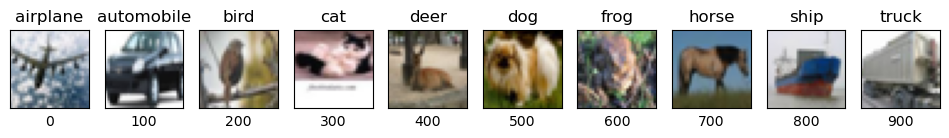

In [142]:
indices_to_inspect = range(0, 1000, 100)

fig, ax = plt.subplots(1, 10)
fig.set_size_inches(12, 1.2)

for i, each_image in enumerate(indices_to_inspect):
    ax[i].imshow(image_train[each_image].reshape(32, 32, 3))
    ax[i].tick_params(left=False)
    ax[i].tick_params(bottom=False)
    ax[i].tick_params(labelleft=False)
    ax[i].tick_params(labelbottom=False)
    ax[i].set_xlabel(f"{each_image}")
    ax[i].set_title(f"{label_train[each_image]}")

## KNN

### Model Building

Now it's time to make your own implementation of the k-Nearest Neighbors algorithm.

<span style="color:blue;font-weight:bold">Code Block #2: Building the model</span>

Create a KNN model, or an instance of the class KNN_Model and fit it with the train dataset. 
- Although, `k_neighbors` can be any integer in theory, keep `k_neighbors == 9` in this homework assignment. 
- The name of the KNN_Model instance must be `model_cifar`, so that you can run the following Code Blocks without trouble.

In [143]:
from KNN_Model import KNN_Model

## TODO
model_cifar = KNN_Model(cifar_class_list, 9)
model_cifar.fit(image_train, label_train)

### Model Visualization

<span style="color:blue;font-weight:bold">Code Block #3: Interacting with the model</span>

Text(0.5, 1.0, 'MY CIFAR Digit Example')

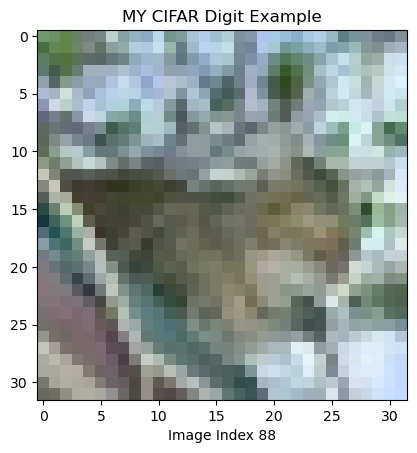

In [144]:
## Pull in a specific image
sample_image = image_test[88].copy()
## TODO: Show what the image looks like using plt.imshow
## Make sure to title it using plt.title
plt.imshow(sample_image.reshape(32, 32, 3), cmap = "Greys")
plt.xlabel("Image Index 88")
plt.title("MY CIFAR Digit Example")

In [145]:
## TODO: Show what the image looks like using plt.imshow
## Make sure to title it using plt.title

In [146]:
## TODO: Figure out the closest k neighbors based on the model.
class_counts, nearest_indices = model_cifar.get_neighbor_counts(sample_image, True)

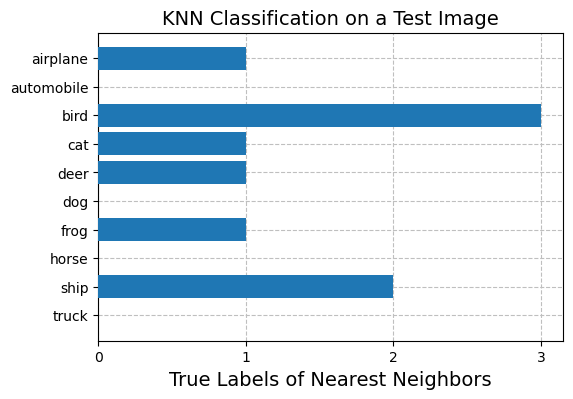

In [147]:
fig_knn, ax_knn = plt.subplots()

ax_knn.barh(y=cifar_class_list, width=class_counts, zorder=100)
ax_knn.invert_yaxis()
ax_knn.set_xticks(np.arange(1 + np.max(class_counts)))
ax_knn.set_yticks(cifar_class_list)
ax_knn.set_title("KNN Classification on a Test Image", fontsize=14)
ax_knn.set_xlabel("True Labels of Nearest Neighbors", fontsize=14)
ax_knn.grid(linestyle="dashed", color="#bfbfbf", zorder=-100)
fig_knn.set_size_inches([6, 4])

## You can also save the figure in the pdf, png, and svg formats
# fig.savefig(f"KNN_Test_Image_CIFAR.png", dpi=300, bbox_inches="tight")

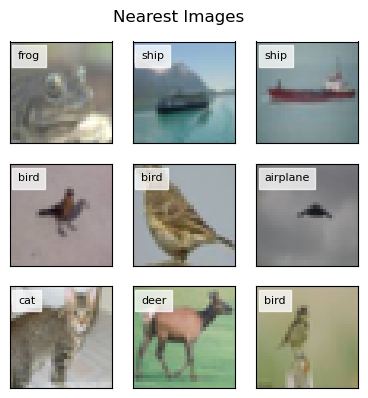

In [148]:
fig_nearest, ax_nearest = plt.subplots(3, 3, figsize=(4.5, 4.5))

for each_ax, each_neighbor in zip(ax_nearest.flat, nearest_indices):
    each_ax.imshow(model_cifar.image_train[each_neighbor].reshape(32, 32, 3), cmap="Greys")
    each_ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    each_ax.text(2, 5, model_cifar.label_train[each_neighbor], 
        fontsize=8, bbox = dict(color="White", alpha=0.75))
    fig_nearest.suptitle("Nearest Images", y = 0.95)

## Evaluation

It is time to evaluate the model.

### Overall Accuracy

<span style="color:blue;font-weight:bold">Code Block #4: Overall accuracy</span>

1. Get predictions on every image in the test dataset. 
2. Calculate and print out the overall accuracy of the model, which is defined as the number of correct predictions divided by the number of all predictions.

In [149]:
%%time
## TODO: Get the accuracy on the test dataset
prediction_array = model_cifar.get_prediction_array(image_test)
print(prediction_array.size)
k = 0
for i, j in enumerate(prediction_array):
    if str(label_test[i]) in str(j):
        k+=1

prediction_acc = k/prediction_array.size
print(f"accuracy = {prediction_acc}")

progressing... 
progressing... 
progressing... 
250
accuracy = 0.232
CPU times: user 1.43 s, sys: 238 ms, total: 1.67 s
Wall time: 1.68 s


### Confusion Matrix 

<span style="color:blue;font-weight:bold">Code Block #5: Confusion matrix</span>

In [150]:
# TODO: Get the confusion matrix (hint: see KNN_ConfMtx)

confusion_mat = model_cifar.get_confusion_matrix(label_test, prediction_array)
print(confusion_mat)

[[ 8  1  9  0  5  0  0  0  2  0]
 [ 3  2  9  0  2  0  1  0  8  0]
 [ 1  0  9  1  7  0  3  1  3  0]
 [ 2  0  9  4  5  1  2  1  1  0]
 [ 2  0  8  1 10  0  1  2  1  0]
 [ 3  0  9  2  4  5  2  0  0  0]
 [ 0  0 11  0  8  1  5  0  0  0]
 [ 8  1  6  1  3  1  2  2  1  0]
 [ 5  0  4  1  2  0  1  0 12  0]
 [ 5  2  3  1  5  0  1  3  4  1]]


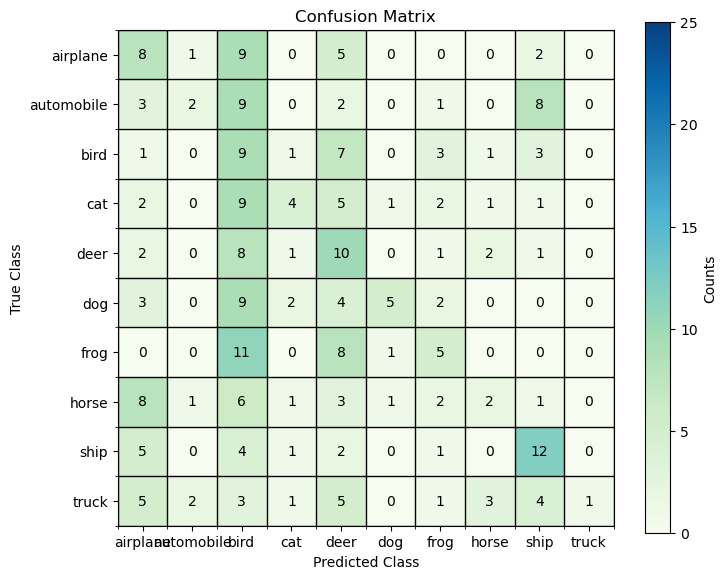

In [151]:
fig_confusion1, ax_confusion1 = model_cifar.visualize_confusion_matrix(confusion_mat)

## Pretrained ResNet50

### KNN on ResNet Embeddings

<span style="color:blue;font-weight:bold">Code Block #6: More preprocessing for ResNet50</span>

From now on, use `image_train_embeddings` instead of `image_train`, and use `image_test_embeddings` instead of `image_test`.

In [ ]:
%%time

rs_wrapper = ResNetWrapper()

image_train_resnet = rs_wrapper.preprocess_image(image_train_uint)
image_test_resnet  = rs_wrapper.preprocess_image(image_test_uint)

image_train_embeddings = rs_wrapper.get_resnet_embeddings(image_train_resnet)
image_test_embeddings  = rs_wrapper.get_resnet_embeddings(image_test_resnet)

<span style="color:blue;font-weight:bold">Code Block #7: Building the model again, because ResNet</span>

Create a KNN model, or an instance of the class KNN_Model and fit it with the train dataset. 
- Although, `k_neighbors` can be any integer in theory, keep `k_neighbors == 9` in this homework assignment. 
- The name of the KNN_Model instance must be `model_resnet`, so that you can run the following Code Blocks without trouble.

In [ ]:
## TODO: Train the KNN Model on the ResNet embeddings of the trained data
model_resnet = None

<span style="color:blue;font-weight:bold">Code Block #8: Overall accuracy of KNN + ResNet</span>

1. Get predictions on every image embeddings in the test dataset. 
2. Calculate and print out the overall accuracy of the model, which is defined as the number of correct predictions divided by the number of all predictions.

In [ ]:
%%time
## TODO: Get testing accuracy on model working with ResNet embeddings
prediction_array2 = None
prediction_acc2 = None
print(f"accuracy = {prediction_acc2}")

<span style="color:blue;font-weight:bold">Code Block #9: Confusion matrix of KNN + ResNet</span>

In [ ]:
## TODO: Compute the confusion matrix for this new model as before
confusion_mat2 = None
print(confusion_mat2)

In [ ]:
fig_confusion2, ax_confusion2 = model_resnet.visualize_confusion_matrix(confusion_mat2)

In [ ]:
class_counts, nearest_indices = model_resnet.get_neighbor_counts(image_test_embeddings[88], return_indices=True)
print(class_counts)

In [ ]:
fig_resnet, ax_resnet = plt.subplots()

class_counts, nearest_indices = model_resnet.get_neighbor_counts(image_test_embeddings[88], return_indices=True)
ax_resnet.barh(y=cifar_class_list, width=class_counts, zorder=100)
ax_resnet.invert_yaxis()
ax_resnet.set_xticks(np.arange(1 + np.max(class_counts)))
ax_resnet.set_yticks(cifar_class_list)
ax_resnet.set_title("KNN-Resnet Hybrid Classification on a Test Image", fontsize = 14)
ax_resnet.set_xlabel("True Labels of Nearest Neighbors", fontsize = 14)
ax_resnet.grid(linestyle="dashed", color="#bfbfbf", zorder= -100)
fig_resnet.set_size_inches([6, 4])

In [ ]:
fig_nearest2, ax_nearest2 = plt.subplots(3, 3, figsize=(4.5, 4.5))

for each_ax, each_neighbor in zip(ax_nearest2.flat, nearest_indices):
    each_ax.imshow(image_train_uint[each_neighbor], cmap="Greys")
    each_ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    each_ax.text(2, 5, label_train[each_neighbor], 
        fontsize=8, bbox = dict(color="White", alpha=0.75))
    fig_nearest2.suptitle("Nearest Images", y = 0.95)

### Full ResNet Model

In [ ]:
fig_compare, ax_compare = plt.subplots(1, 2)
ax_compare[0].imshow(image_test_uint[88])
ax_compare[1].imshow(plt.imread(kitten_path))

<span style="color:blue;font-weight:bold">Code Block #10: Full power of the ResNet50 model</span>

In [ ]:
print(rs_wrapper.get_full_model_predictions(image_test_resnet[88]))

kitten_image_full = plt.imread(kitten_path)
kitten_image_full = np.array(kitten_image_full)

## TODO: Get the ResNet model predictions on the kitten image above